In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Use case: credit card fraud detection

Bank digitalization, new payment methods, and 24/7 access to financial institutions increase vulnerability and require redesigning current security methods. Banks are becoming more prone to attacks, which results in rising complexities and costs to comply with financial crimes regulations.

In this use case, we will consider a problem of fraud detection in credit card transaction data and identify how quantum computing can help to detect anomalies in transactions. We will compare results with classical methods.

We will use a data set from the Kaggle competition.<sup>1</sup> This data set presents transactions that occurred in two days (Sep 2013, EU), where we have 492 frauds out of 284,807 transactions. The data set is highly unbalanced, as the positive class (frauds) accounts for 0.172% of all transactions.

In [2]:
# Standard packages
import numpy as np, pandas as pd
import sklearn, random, itertools
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.svm import SVC
#from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_curve,auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit
import qiskit
from qiskit.circuit.library import PauliFeatureMap

## Data

In order for calculations to take a reasonable amount of time to complete during the training class, we are going to use only five predictors: V1-V5. Since the data is composed of principal components from the original data, we can reasonably expect that these variables are also among the most important ones (however, this is not explicitly stated in the data description). We leave this as an exercise for you to test a different set of predictor variables.

The data is broken into training, validation, and test sets. Models are trained on the train data, and the validation set is used to pick the best model during the grid search. The test set is a completely independent set of data, not seen by the model during the training. Note that the data also has a time variable in it; you can create an out-of-time data set, separated from training on a time axis, as a separate exercise. We’ll use about 60% of the original data for training and 20% each for validation and testing. The data is balanced to have 50% fraudulent and 50% genuine transactions in each data set. For convenience, we created appropriate samples from the raw input data that we import in the code below.

In [3]:
# Read the data, split subsets
data_df = pd.read_pickle("data/creditcard.zip", \
                         compression = 'zip')
X_train = data_df[data_df["sample"]==0].drop(columns=["sample","y"])
X_test = data_df[data_df["sample"]==2].drop(columns=["sample","y"])
X_val = data_df[data_df["sample"]==1].drop(columns=["sample","y"])
y_train = data_df[data_df["sample"]==0]["y"]
y_test = data_df[data_df["sample"]==2]["y"]
y_val = data_df[data_df["sample"]==1]["y"]

# Standardize
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

# Normalize
mms = MinMaxScaler((-1, 1))
X_train = mms.fit_transform(X_train)
X_val = mms.transform(X_val)
X_test = mms.transform(X_test)

print("Train set shape", X_train.shape, \
      ", average fraud rate = ",np.mean(y_train),\
      "\nValidation set shape", \
      X_val.shape, ", average fraud rate = ", \
      np.mean(y_val),"\nTest set shape", \
      X_test.shape,", average fraud rate = ",np.mean(y_test))

Train set shape (586, 5) , average fraud rate =  0.5 
Validation set shape (202, 5) , average fraud rate =  0.5 
Test set shape (196, 5) , average fraud rate =  0.5


## Data visualization
It is always helpful to visualize the data before the analysis. Below we draw a pairwise relationship plot, separating fraudulent (“1”) and non-fraudulent (“0”) transactions.

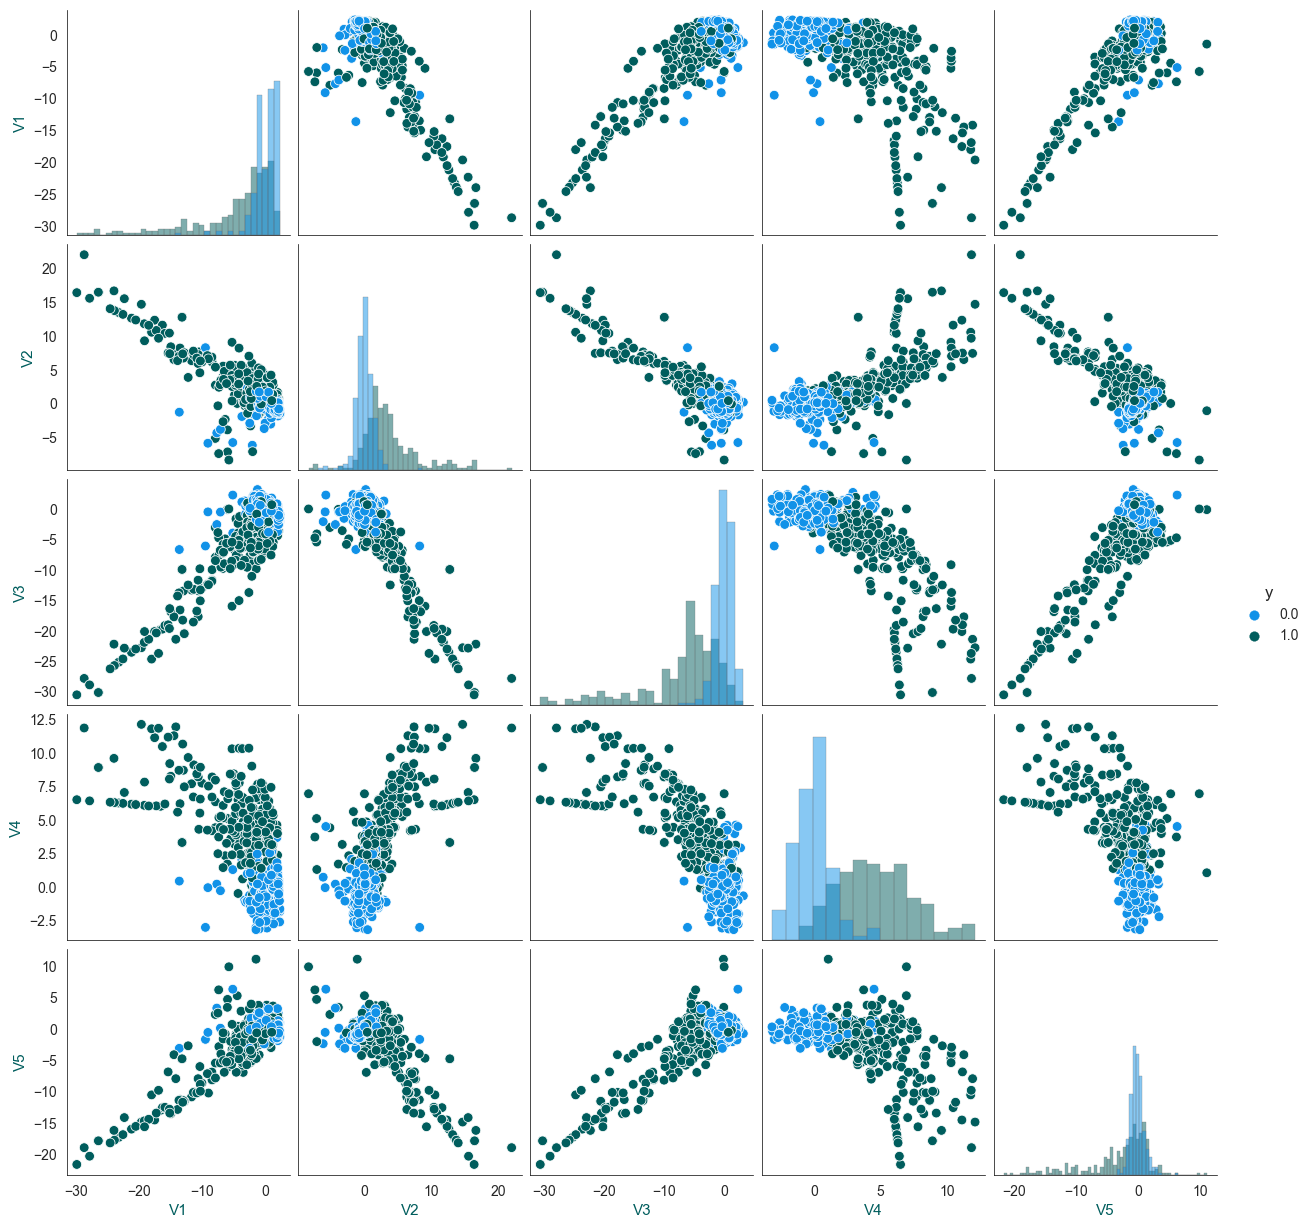

In [4]:
sns.pairplot(data_df[data_df["sample"]==0].drop(columns=["sample"]),hue="y", diag_kind="hist")
plt.show()

Scatter plots show nonlinear dependencies between different features. The histograms indicate higher-density distributions of feature values for regular transactions and longer tails for fraudulent cases, as we would expect.

## Predefined split for training and validation

In order to do a fair comparison between quantum and classical models, we must ensure they are trained and tested on exactly the same data sets. We accomplish this with ``PredefinedSplit``, as shown below. We merge training and validation data together.

In [5]:
X_train_val = np.concatenate((X_train, X_val),axis=0)
y_train_val = np.concatenate((y_train, y_val),axis=0)

predefined_split = np.concatenate(([-1]*y_train.shape[0], \
                                   [0]*y_val.shape[0]))
ps = PredefinedSplit(predefined_split)

We first start with a quantum model.

# Support vector machines with quantum kernel estimation
## Hyperparameter search

Next, we define the parameter grid for the kernel, transform it into a list of kernels, and capture kernel/parameter references in a dictionary object. We now can look up parameters that correspond to the selected kernel.<br>

Note that we use only a limited parameter grid to make the process complete in a reasonable amount of time.

In [6]:
from functools import lru_cache
from qiskit_machine_learning.kernels import fidelity_statevector_kernel

class FidelityStatevectorKernel(fidelity_statevector_kernel.FidelityStatevectorKernel):
    """Extends `qiskit_machine_learning.kernels.fidelity_statevector_kernel.FidelityStatevectorKernel`
    so that it can be pickled.  This is necessary to save and load object and use many parallel
    processing frameworks like ray and sklearn which require pickling objects to work.
    Maintaining this until the qiskit `FidelityStatevectorKernel` is fixed, at which point this
    will be set equal to the qiskit class and deprecated.  Fix progress can be tracked in the
    following github issue: https://github.com/Qiskit/qiskit-machine-learning/issues/607
    """

    def __getstate__(self):
        result = self.__dict__.copy()
        result["_get_statevector"] = None
        result["_lru_cache_maxsize"] = self._get_statevector.cache_parameters()[
            "maxsize"
        ]
        return result

    def __setstate__(self, state):
        max_size = state["_lru_cache_maxsize"]
        del state["_lru_cache_maxsize"]
        self.__dict__ = state
        self._get_statevector = lru_cache(maxsize=max_size)(self._get_statevector_)

class FidelityStatevectorKernel(fidelity_statevector_kernel.FidelityStatevectorKernel):
    """Extends `qiskit_machine_learning.kernels.fidelity_statevector_kernel.FidelityStatevectorKernel`
    so that it can be pickled.  This is necessary to save and load object and use many parallel
    processing frameworks like ray and sklearn which require pickling objects to work.
    Maintaining this until the qiskit `FidelityStatevectorKernel` is fixed, at which point this
    will be set equal to the qiskit class and deprecated.  Fix progress can be tracked in the
    following github issue: https://github.com/Qiskit/qiskit-machine-learning/issues/607
    """

    def __getstate__(self):
        result = self.__dict__.copy()
        result["_get_statevector"] = None
        result["_lru_cache_maxsize"] = self._get_statevector.cache_parameters()[
            "maxsize"
        ]
        return result

    def __setstate__(self, state):
        max_size = state["_lru_cache_maxsize"]
        del state["_lru_cache_maxsize"]
        self.__dict__ = state
        self._get_statevector = lru_cache(maxsize=max_size)(self._get_statevector_)

In [7]:
kernels = [] # list for kernel callables
kernels_dict = dict() # dictionary for lookup of kernel parameters

# Kernels grid
grid_params_kernel = dict()
grid_params_kernel["alpha"] = [0.5,1,2]
grid_params_kernel["paulis"] = [["Y"],["Z"],["YZ"],["ZZ"]]
grid_params_kernel["reps"] = [1]
grid_params_kernel["entanglement"] = ["full"]

feature_dim = X_train.shape[1]

# Extracting all combinations of kernel parameters
grid_params_kernel_values = \
    list(itertools.product(*grid_params_kernel.values()))

# Converting parameters grid into list of kernel callables
for alpha,pauli,reps,entanglement in grid_params_kernel_values:

    feature_map = PauliFeatureMap(feature_dimension=feature_dim, \
                                  alpha=alpha, \
                                  reps=reps, \
                                  paulis=pauli, \
                                  entanglement=entanglement \
                                 )
    kernel = FidelityStatevectorKernel(feature_map=feature_map)

    obj_str = str(kernel)
    obj_str = obj_str[obj_str.find("0x"):-1]

    kernels_dict[obj_str] = {"alpha":alpha, \
                             "paulis":pauli, \
                             "reps":reps, \
                             "entanglement":entanglement
                            }

    kernels.append(kernel.evaluate)

Next, we combine the kernel grid with classical model parameters and start estimation.

<b>Note:</b> Currently we use the statevector simulator, so for smaller problems it makes sense to run multiple jobs in parallel. If you use the physical backend, you may want to run tasks sequentially and utilize Qiskit Runtime.

In [8]:
# Define classical parameter grid for SVM with quantum kernel
params_qsvc = {'C':[1,10]}
# We use kernel objects themselves as parameters. 
# After the training we would need to map the selected kernel 
# back to kernel parameters.
params_qsvc['kernel'] = kernels

# estimator to be used in GridSearchCV
svc = SVC(probability=True) 

# Define grid search estimator with parameters grid, 
# predefined split and parallel processing
estimator_q = GridSearchCV(svc, params_qsvc, n_jobs=4, verbose=1, cv=ps)
estimator_q.fit(X = X_train_val,y = y_train_val)

# The next line is very verbose. Please, uncomment to see 
# detailed results.
#print("All results -----------\n", estimator.cv_results_)
print("Best ------------------\n", estimator_q.best_params_)
q_kernel_obj_str = str(estimator_q.best_params_.get('kernel'))
# Retrieving kernel parameters for the best kernel
q_kernel_obj_str = q_kernel_obj_str[q_kernel_obj_str.find("0x"):-2]
print("Best kernel -----------\n",kernels_dict[q_kernel_obj_str])

Fitting 1 folds for each of 24 candidates, totalling 24 fits
Best ------------------
 {'C': 1, 'kernel': <bound method FidelityStatevectorKernel.evaluate of <__main__.FidelityStatevectorKernel object at 0x7fa8d9b8c040>>}
Best kernel -----------
 {'alpha': 1, 'paulis': ['ZZ'], 'reps': 1, 'entanglement': 'full'}


In [9]:
# Retrieve kernel parameters for grid search iterations
test_scores = estimator_q.cv_results_['split0_test_score']
params = estimator_q.cv_results_['params']

for i_param in params:
    q_kernel_obj_str = str(i_param['kernel'])
    q_kernel_obj_str = q_kernel_obj_str[q_kernel_obj_str.find("0x"):-2]
    i_param["kernel"] = kernels_dict[q_kernel_obj_str]

for i,i_param in enumerate(params):
    i_param['test_score'] = test_scores[i]

Printing results of the grid search:

In [10]:
with pd.option_context('display.max_rows', None, \
                       'display.max_columns', None, \
                       'max_colwidth', 1, \
                       'display.width', 1000 \
                      ):
    print(pd.DataFrame(params))

     C                                                               kernel  test_score
0   1   {'alpha': 0.5, 'paulis': ['Y'], 'reps': 1, 'entanglement': 'full'}   0.881188  
1   1   {'alpha': 0.5, 'paulis': ['Z'], 'reps': 1, 'entanglement': 'full'}   0.881188  
2   1   {'alpha': 0.5, 'paulis': ['YZ'], 'reps': 1, 'entanglement': 'full'}  0.915842  
3   1   {'alpha': 0.5, 'paulis': ['ZZ'], 'reps': 1, 'entanglement': 'full'}  0.925743  
4   1   {'alpha': 1, 'paulis': ['Y'], 'reps': 1, 'entanglement': 'full'}     0.915842  
5   1   {'alpha': 1, 'paulis': ['Z'], 'reps': 1, 'entanglement': 'full'}     0.915842  
6   1   {'alpha': 1, 'paulis': ['YZ'], 'reps': 1, 'entanglement': 'full'}    0.920792  
7   1   {'alpha': 1, 'paulis': ['ZZ'], 'reps': 1, 'entanglement': 'full'}    0.945545  
8   1   {'alpha': 2, 'paulis': ['Y'], 'reps': 1, 'entanglement': 'full'}     0.910891  
9   1   {'alpha': 2, 'paulis': ['Z'], 'reps': 1, 'entanglement': 'full'}     0.910891  
10  1   {'alpha': 2, 'paulis': [

The grid search was performed on both classical and quantum kernel parameters. You can print out the full history of results. In general, you can use this procedure to choose the best model as well as to assist in finding the most suitable quantum kernel and feature map topology.<br>

Below, we print out classification metrics (classification report, receiver operatoring characteristic (ROC) curves).

In [11]:
y_train_pred = estimator_q.best_estimator_.predict(X_train)
y_train_pred_scores = estimator_q.best_estimator_.predict_proba(X_train)
y_test_pred_q = estimator_q.best_estimator_.predict(X_test)
y_test_pred_scores_q = estimator_q.best_estimator_.predict_proba(X_test)
y_val_pred = estimator_q.best_estimator_.predict(X_val)
y_val_pred_scores = estimator_q.best_estimator_.predict_proba(X_val)
print("Confusion matrix, Test \n",confusion_matrix(y_test, y_test_pred_q))
print("Confusion matrix, Train \n",confusion_matrix(y_train, y_train_pred))
print("Confusion matrix, Validation \n",confusion_matrix(y_val, y_val_pred))
#print(classification_report(y_test, y_test_pred))
accuracy = accuracy_score(y_test, y_test_pred_q)
print("Accuracy test: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy train: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy val: %.2f%%" % (accuracy * 100.0))

cr_train = classification_report(y_train, y_train_pred,output_dict=False)
cr_test = classification_report(y_test, y_test_pred_q,output_dict=False)
cr_val = classification_report(y_val, y_val_pred,output_dict=False)

print('train',cr_train,'\nval',cr_val,'\ntest',cr_test)

Confusion matrix, Test 
 [[91  7]
 [10 88]]
Confusion matrix, Train 
 [[285   8]
 [ 31 262]]
Confusion matrix, Validation 
 [[97  4]
 [ 8 93]]
Accuracy test: 91.33%
Accuracy train: 93.34%
Accuracy val: 94.06%
train               precision    recall  f1-score   support

         0.0       0.90      0.97      0.94       293
         1.0       0.97      0.89      0.93       293

    accuracy                           0.93       586
   macro avg       0.94      0.93      0.93       586
weighted avg       0.94      0.93      0.93       586
 
val               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       101
         1.0       0.96      0.92      0.94       101

    accuracy                           0.94       202
   macro avg       0.94      0.94      0.94       202
weighted avg       0.94      0.94      0.94       202
 
test               precision    recall  f1-score   support

         0.0       0.90      0.93      0.91        98
         1.

Visualizing results using ROC curves:

The ROC curve plots false positives versus true positives. The further the line is from the random 45-degree line, the better is the classifier. A metric called the “area under the curve” (AUC) provides a single-number summary of the ROC curve.

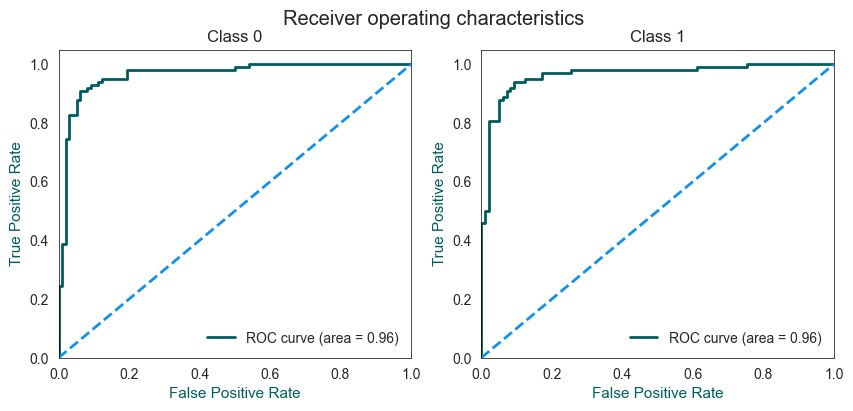

In [12]:
fpr = dict()
tpr = dict()
roc_auc = dict()

fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Receiver operating characteristics')
lw = 2

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve((np.array([[0,1] if row==1 else [1,0] for row in y_test]))[:, i], y_test_pred_scores_q[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    axs[i].plot(fpr[i], tpr[i], color='#005D5D',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    axs[i].plot([0, 1], [0, 1], color='#1192E8', lw=lw, linestyle='--')
    axs[i].set_title("Class %0.0f" % i)
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].legend(loc="lower right")
    
plt.show()

Next, we train the support vector machine (SVM) with classical kernels and perform hyperparameter tuning.

# Classic SVM

In [13]:
# Specify grid for SVM
parameters_svm = {'kernel':('linear', 'rbf'), \
              'C':[0.1, 1, 10, 100], \
              'gamma':['scale', 'auto',0.0001,0.001,0.01,0.1,1,10], \
              'probability': [True]
             }
# Initialize classifier and fit
svc = SVC()
estimator_r = GridSearchCV(svc, parameters_svm, n_jobs=-1, \
                           verbose=1, cv=ps)
estimator_r.fit(X = X_train_val,y = y_train_val)

selected_params = estimator_r.best_estimator_.get_params()
selected_params = {k: selected_params[k] for k in \
                   parameters_svm.keys()}

print("Selected parameters:/n",selected_params)

Fitting 1 folds for each of 64 candidates, totalling 64 fits
Selected parameters:/n {'kernel': 'rbf', 'C': 1, 'gamma': 10, 'probability': True}


Printing classification results:

In [14]:
y_train_pred = estimator_r.best_estimator_.predict(X_train)
y_train_pred_scores = estimator_r.best_estimator_.predict_proba(X_train)
y_test_pred_r = estimator_r.best_estimator_.predict(X_test)
y_test_pred_scores_r = estimator_r.best_estimator_.predict_proba(X_test)
y_val_pred = estimator_r.best_estimator_.predict(X_val)
y_val_pred_scores = estimator_r.best_estimator_.predict_proba(X_val)
print("Confusion matrix, Test \n",confusion_matrix(y_test, y_test_pred_r))
print("Confusion matrix, Train \n",confusion_matrix(y_train, y_train_pred))
print("Confusion matrix, Validation \n",confusion_matrix(y_val, y_val_pred))
accuracy = accuracy_score(y_test, y_test_pred_r)
print("Accuracy test: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy train: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy val: %.2f%%" % (accuracy * 100.0))

cr_train = classification_report(y_train, y_train_pred,output_dict=False)
cr_test = classification_report(y_test, y_test_pred_r,output_dict=False)
cr_val = classification_report(y_val, y_val_pred,output_dict=False)

print('train',cr_train,'\nval',cr_val,'\ntest',cr_test)

# Retrieve parameters for grid search iterations
test_scores = estimator_r.cv_results_['split0_test_score']
params = estimator_r.cv_results_['params']

for i,i_param in enumerate(params):
    i_param['test_score'] = test_scores[i]
    i_param['alpha'] = i_param['kernel'][0]
    
with pd.option_context('display.max_rows', None, \
                       'display.max_columns', None):
    print(pd.DataFrame(params))

Confusion matrix, Test 
 [[92  6]
 [ 9 89]]
Confusion matrix, Train 
 [[285   8]
 [ 26 267]]
Confusion matrix, Validation 
 [[98  3]
 [ 8 93]]
Accuracy test: 92.35%
Accuracy train: 94.20%
Accuracy val: 94.55%
train               precision    recall  f1-score   support

         0.0       0.92      0.97      0.94       293
         1.0       0.97      0.91      0.94       293

    accuracy                           0.94       586
   macro avg       0.94      0.94      0.94       586
weighted avg       0.94      0.94      0.94       586
 
val               precision    recall  f1-score   support

         0.0       0.92      0.97      0.95       101
         1.0       0.97      0.92      0.94       101

    accuracy                           0.95       202
   macro avg       0.95      0.95      0.95       202
weighted avg       0.95      0.95      0.95       202
 
test               precision    recall  f1-score   support

         0.0       0.91      0.94      0.92        98
         1.

Visualizing results using ROC curves:

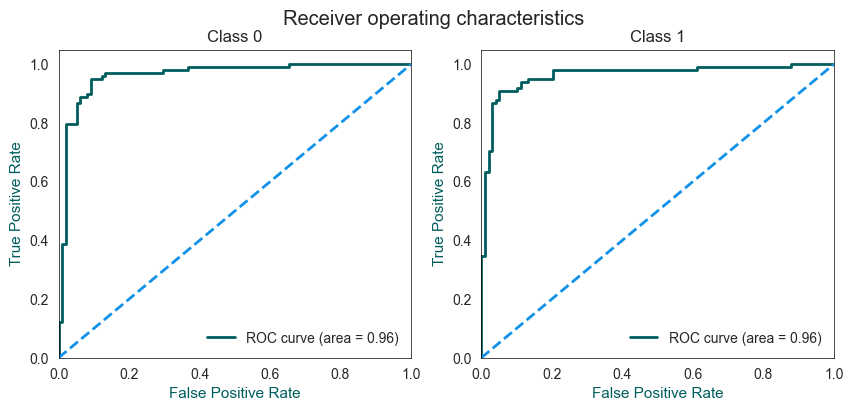

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()

fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Receiver operating characteristics')
lw = 2

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve((np.array([[0,1] if row==1 else [1,0] for row in y_test]))[:, i], y_test_pred_scores_r[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    axs[i].plot(fpr[i], tpr[i], color='#005D5D',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    axs[i].plot([0, 1], [0, 1], color='#1192E8', lw=lw, linestyle='--')
    axs[i].set_title("Class %0.0f" % i)
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].legend(loc="lower right")
    
plt.show()

# Results comparison

When we examine misclassifications on the test set, we observe a strong correlation between the classical SVM and the SVM based on the quantum kernel. In only a few instances did the models produce different predictions, as the table below shows.

In [16]:
pd.DataFrame(np.array(list(zip(
                y_test[(y_test_pred_q != y_test) | (y_test_pred_r != y_test)], \
                y_test_pred_q[(y_test_pred_q != y_test) | (y_test_pred_r != y_test)], \
                [max(score1) for score1 in y_test_pred_scores_q[(y_test_pred_q != y_test) | (y_test_pred_r != y_test)]], \
                y_test_pred_r[(y_test_pred_q != y_test) | (y_test_pred_r != y_test)], \
                [max(score2) for score2 in y_test_pred_scores_r[(y_test_pred_q != y_test) | (y_test_pred_r != y_test)]]))),
             columns=["obs","pred_q","score_q","pred_r","score_r"], \
             index = list(y_test[(y_test_pred_q != y_test) | (y_test_pred_r != y_test)].index)
            )

obs  pred_q   score_q  pred_r   score_r
791  1.0     0.0  0.699576     0.0  0.730230
801  1.0     0.0  0.543502     1.0  0.653665
804  1.0     0.0  0.885732     0.0  0.890825
814  1.0     0.0  0.838991     0.0  0.887443
827  1.0     0.0  0.526160     0.0  0.681092
840  1.0     0.0  0.574542     0.0  0.705979
844  1.0     0.0  0.932925     0.0  0.939331
850  1.0     0.0  0.848926     0.0  0.888291
858  1.0     0.0  0.949211     0.0  0.954372
870  1.0     1.0  0.569318     0.0  0.542405
885  1.0     0.0  0.513593     1.0  0.733542
887  0.0     1.0  0.950922     1.0  0.971173
896  0.0     1.0  0.577660     0.0  0.866596
908  0.0     1.0  0.848791     1.0  0.952739
911  0.0     1.0  0.843117     1.0  0.735229
913  0.0     1.0  0.836593     1.0  0.853158
961  0.0     1.0  0.637893     1.0  0.623402
976  0.0     1.0  0.954066     1.0  0.959086

We observe very similar results in model performance when we compare support vector classifiers using classical kernels with those using quantum kernels. Of course, this doesn’t show an advantage over classical models. This demonstration shows that quantum models can perform as well as classical ones on relatively small classical data. We can reasonably believe that data sets exist where the data lends itself better to the quantum kernel. However, to examine this possibility, we may need to run calculations on real quantum hardware so we can operate with more input variables.

## Reference

1. “Credit Card Fraud Detection: Anonymized Credit Card Transactions Labeled as Fraudulent or Genuine.” *Kaggle*. 2018. https://www.kaggle.com/mlg-ulb/creditcardfraud.

In [17]:
sklearn.show_versions()


System:
    python: 3.9.16 (main, Mar  8 2023, 04:29:44)  [Clang 14.0.6 ]
executable: /Users/laura/opt/anaconda3/envs/test_essentials_qml/bin/python
   machine: macOS-10.16-x86_64-i386-64bit

Python dependencies:
      sklearn: 1.2.2
          pip: 23.0.1
   setuptools: 66.0.0
        numpy: 1.23.5
        scipy: 1.10.1
       Cython: None
       pandas: 2.0.0
   matplotlib: 3.7.1
       joblib: 1.2.0
threadpoolctl: 3.1.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
         prefix: libopenblas
       filepath: /Users/laura/opt/anaconda3/envs/test_essentials_qml/lib/python3.9/site-packages/numpy/.dylibs/libopenblas64_.0.dylib
        version: 0.3.20
threading_layer: pthreads
   architecture: Haswell
    num_threads: 2

       user_api: openmp
   internal_api: openmp
         prefix: libomp
       filepath: /Users/laura/opt/anaconda3/envs/test_essentials_qml/lib/python3.9/site-packages/sklearn/.dylibs/libomp.dylib
        version: None
 

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>